#!/usr/bin/env python
coding: utf-8


"""
Created on Thu May 28 12:04:02 2020

@author: David R McKenna
"""


# COVID-19 Notebook- Tracking The Virus in UT and CA
## By David R McKenna


In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import requests, json
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Import the latest data 
 
### The data is imported from the covidtracking.com website. 

In [2]:
url = 'https://covidtracking.com/api/v1/states/daily.json'

r = requests.get(url)

json_data = r.json()

df = pd.json_normalize(json_data)

# Add columns Deaths per Positive case (DperP), Positive per Test (PosPerTest),
# and Total Increase Minus Hosptialized Increase (TotMinusHosptializedIncresase)

df['DperP'] = df['death']/df['positive']
df['PosPerTest']= df['positiveIncrease']/df['totalTestResultsIncrease']*100
df['TotMinusHosptializedIncresase'] = np.abs(df['positiveIncrease'] - df['hospitalizedIncrease'])

df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d') #convert date to datetime object and make index
df.set_index('date')



plt.close('all')
#df.to_excel('df.xlsx')


## Setup global characteristics for plots. 
Plots will have the basic seaborn apearance and will have a watermork with attributions. 


In [3]:
                 ### Subset the data for specific states ### 
sns.set()
# First we look at Utah

def watermark(loc_x = 0.92, loc_y =0.15):
    """ Puts Property Of David McKenna on LRH corner of plots"""
    
    fig.text(loc_x,loc_y, 'Property of David McKenna \n data from: covidtracking.com',
         fontsize=10, color='gray', rotation=270,
         ha='right', va='bottom', alpha=0.75)
    
def date_ticks() :
    # Define the date format
    date_form = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(date_form)

    # Ensure a major tick for each week using (interval=7) 
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=30)
    

## Subset and clean data:
I selected UT first because that is where I live. There were some clear outliers so I replaced them with the most probable value. 


In [4]:
UT = df[df['state']=='UT']
UT= UT[UT['date'] >= '2020-03-15' ]

A = UT['hospitalizedIncrease'].loc[lambda x: x==389].index
B = UT['hospitalizedIncrease'].loc[lambda x: x== -365].index
C = UT['positiveIncrease'].loc[lambda x: x== 0].index

UT.loc[A,'hospitalizedIncrease'] = 12
UT.loc[B,'hospitalizedIncrease'] = 12
UT.drop(C,inplace=True)

# Create date ordinal for simplicity of plot labels
UT['date_ordinal'] = pd.to_datetime(UT['date']).apply(lambda date: date.toordinal())


## Define the dates where UT changes thier COVID status' from Red to Orange and Orange to Yellow.
 I added Memorial Day and the start of Protests as well as 7-days after each (hashed-line), to visualize possible effects these events might have on case increases. 


In [5]:
OrangeDate = UT[UT['date']=='2020-04-28']['date_ordinal']
OrangeDate = int(OrangeDate)

YellowDate = UT[UT['date']=='2020-05-14']['date_ordinal']
YellowDate = int(YellowDate)

MemorialDay = UT[UT['date']=='2020-05-25']['date_ordinal']
MemorialDay = int(MemorialDay)

ProtestDate = UT[UT['date']=='2020-05-29']['date_ordinal']
ProtestDate = int(ProtestDate)

def my_annotate(text_loc, text=True) :
    """Setup the anotations of the plots- marking of significant dates"""
    
    ax.axvline(x=OrangeDate, color='tab:orange', linewidth=2)
    ax.axvline( x=YellowDate, color='gold', linewidth=2)
    ax.axvline( x=MemorialDay, color='tab:red', linewidth=1.5)
    ax.axvline( x=ProtestDate, color='tab:purple', linewidth=1.5)
    ax.axvline(x=OrangeDate + 7, color='tab:orange', linewidth=2, linestyle = '--')
    ax.axvline( x=YellowDate + 7, color='gold', linewidth=2, linestyle = '--')
    ax.axvline( x=ProtestDate + 7, color='tab:purple', linewidth=2, linestyle = '--')
    
    if text==True:
        ax.annotate('Code Orange Date', (OrangeDate - 2,text_loc),color='black',rotation=90,fontsize=13)
        ax.annotate('Code Yellow Date', (YellowDate - 2,text_loc),color='black',rotation=90,fontsize=13)
        ax.annotate('Memorial Day', (MemorialDay - 2 ,text_loc),color='black',rotation=90,fontsize=13)
        ax.annotate('Protest Start Date', (ProtestDate - 2 ,text_loc),color='black',rotation=90,fontsize=13)
        ax.annotate('Code Orange + 7-Days', (OrangeDate +5,text_loc),color='black',rotation=90,fontsize=13)
        
print('done')


done


## Plot the Daily Incresase in cases as well as hospitalizations


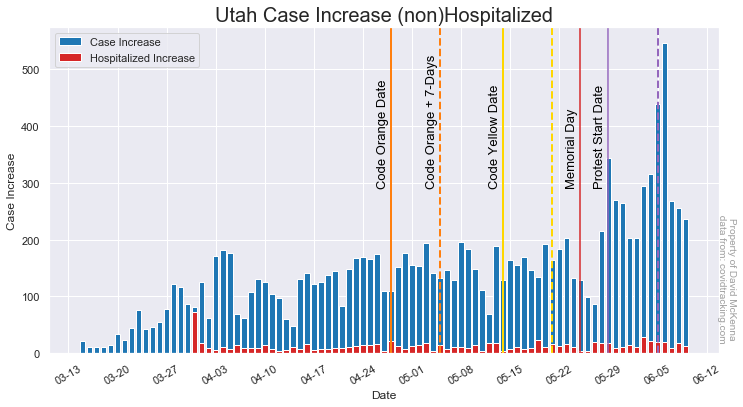

In [6]:
text_loc = max(UT['positiveIncrease'])-250

fig, ax = plt.subplots(figsize = (12,6))
watermark()

ax.bar(UT['date'], UT['positiveIncrease'], label='Case Increase',color='tab:blue')
ax.bar(UT['date'], UT['hospitalizedIncrease'], 
       label='Hospitalized Increase',color='tab:red')

ax.legend(loc='upper left')
my_annotate(text_loc)

date_ticks()

plt.title('Utah Case Increase (non)Hospitalized', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Case Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('Utah_Increase_Hospitalized.png')
plt.show()


## Plot the Daily Case Increase with 3,7,20 day rolling average

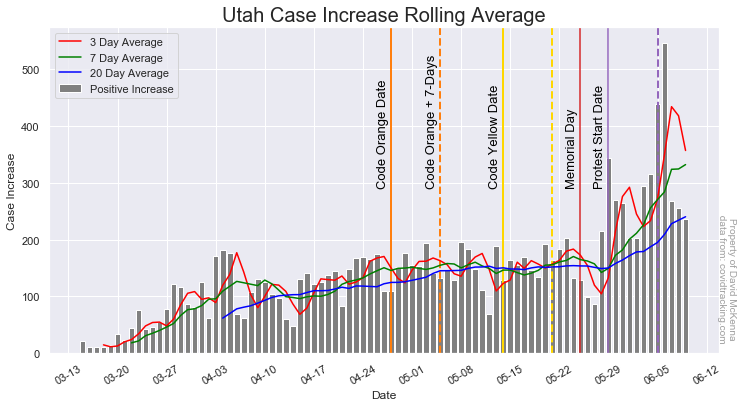

In [7]:
UT['rolling_mean'] = UT.loc[:,'positiveIncrease'].rolling(3).mean().shift(periods=-3)
UT['rolling_mean2'] = UT.loc[:,'positiveIncrease'].rolling(7).mean().shift(periods=-7)
UT['rolling_mean3'] = UT.loc[:,'positiveIncrease'].rolling(20).mean().shift(periods=-20)

fig, ax = plt.subplots(figsize = (12,6))
watermark()

my_annotate(text_loc)
plt.bar(UT['date_ordinal'], UT['positiveIncrease'], label='Positive Increase',color='grey')
plt.plot(UT['date_ordinal'], UT.rolling_mean, label='3 Day Average', color='red')
plt.plot(UT['date_ordinal'], UT.rolling_mean2, label='7 Day Average', color='green')
plt.plot(UT['date_ordinal'], UT.rolling_mean3, label='20 Day Average', color='blue')

date_ticks()

plt.legend(loc='upper left')
plt.title('Utah Case Increase Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Case Increase', fontdict={'fontsize':12})
plt.axis('auto')

#plt.savefig('Utah_Increase_Rolling_Avg.png')
plt.show()


## Plot the Daily Deaths with 3,7,20 day rolling average

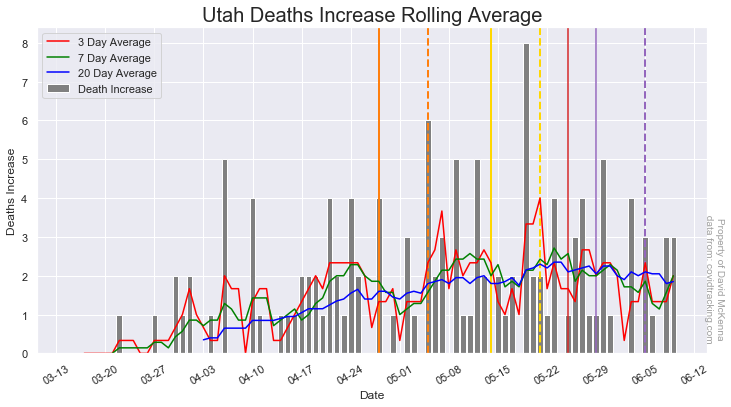

In [8]:
UT['rolling_mean_d'] = UT.loc[:,'deathIncrease'].rolling(3).mean().shift(periods=-2)
UT['rolling_mean_d2'] = UT.loc[:,'deathIncrease'].rolling(7).mean().shift(periods=-6)
UT['rolling_mean_d3'] = UT.loc[:,'deathIncrease'].rolling(20).mean().shift(periods=-19)
#x_dates = UT['date'].dt.strftime('%m-%d').sort_values().unique()
UT['date_ordinal'] = pd.to_datetime(UT['date']).apply(lambda date: date.toordinal())

fig, ax = plt.subplots(figsize = (12,6))
watermark()
my_annotate(text_loc,text=False)
plt.bar(UT['date_ordinal'], UT['deathIncrease'], label='Death Increase',color='grey')
plt.plot(UT['date_ordinal'], UT.rolling_mean_d, label='3 Day Average', color='red')
plt.plot(UT['date_ordinal'], UT.rolling_mean_d2, label='7 Day Average', color='green')
plt.plot(UT['date_ordinal'], UT.rolling_mean_d3, label='20 Day Average', color='blue')
plt.legend(loc='upper left')

date_ticks()

plt.title('Utah Deaths Increase Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Deaths Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('Utah_Death_Rolling_Avg.png')
plt.show()


## Investigating the percentage of tests that return positive results:
#### If this number remains high it shows that we are not testing enough. 



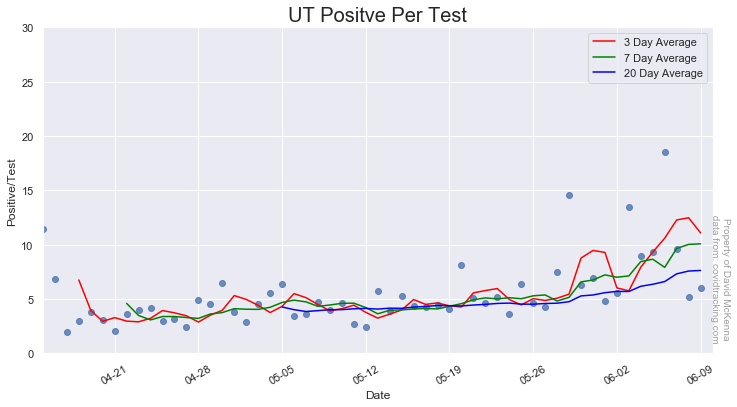

In [9]:
UT_1 = UT[UT['date'] >= '2020-04-15']

UT_1['rolling_mean'] = UT_1.loc[:,'PosPerTest'].rolling(3).mean().shift(periods= -3)
UT_1['rolling_mean2'] = UT_1.loc[:,'PosPerTest'].rolling(7).mean().shift(periods= -7)
UT_1['rolling_mean3'] = UT_1.loc[:,'PosPerTest'].rolling(20).mean().shift(periods= -20)

fig, ax = plt.subplots(figsize = (12,6))
watermark()

fig = sns.regplot(x = 'date_ordinal', y = 'PosPerTest', data = UT, fit_reg=False)
plt.plot(UT_1['date_ordinal'], UT_1.rolling_mean, label='3 Day Average', color='red')
plt.plot(UT_1['date_ordinal'], UT_1.rolling_mean2, label='7 Day Average', color='green')
plt.plot(UT_1['date_ordinal'], UT_1.rolling_mean3, label='20 Day Average', color='blue')

date_ticks()

plt.legend(loc='upper right')
ax.set_xlim(UT_1['date_ordinal'].min() , UT_1['date_ordinal'].max()+1 )
ax.set_ylim(0,30)
plt.title('UT Positve Per Test', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive/Test', fontdict={'fontsize':12})

#plt.savefig('UT_Positive_Per_Test.png')
plt.show()


## Plot the Total tests and which of those are positive

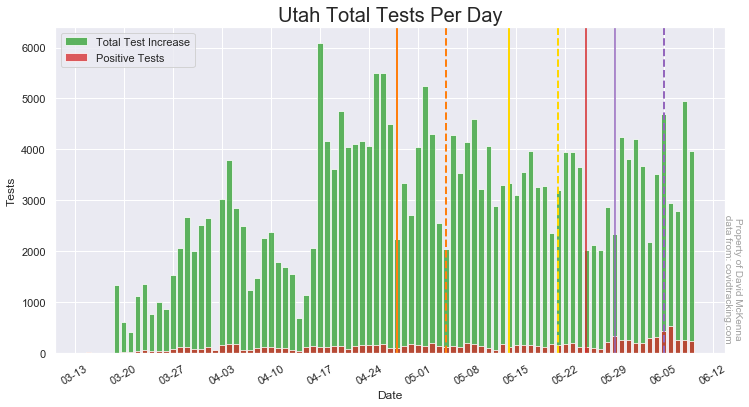

In [10]:
sns.set()

fig, ax = plt.subplots(figsize = (12,6))
watermark()
my_annotate(text_loc,text=False)

ax.bar(UT['date_ordinal'], UT['totalTestResultsIncrease'],
       label='Total Test Increase',color='tab:green',alpha=0.75)
ax.bar(UT['date_ordinal'], UT['positiveIncrease'],
       label='Positive Tests',color='tab:red',alpha=0.75)

date_ticks()

ax.legend(loc='upper left')
plt.title('Utah Total Tests Per Day', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Tests', fontdict={'fontsize':12})
plt.axis('tight')
#plt.savefig('Utah_Increase_Test.png')

plt.show()


## Here it is easier to see the Total Tests, Positive Tests, and the Positive per Test

It is clear the the Total Tests per day is decreasing while the Positive Tests per day is increasing, this yields a proportional increase in Positives per Test. 

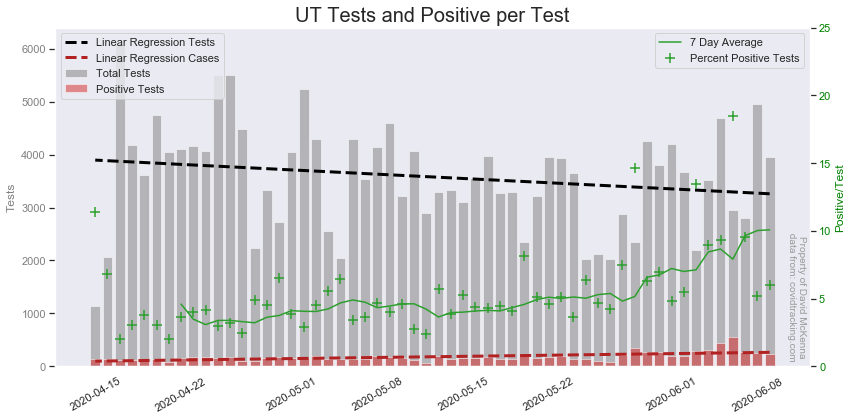

In [11]:
UT_1['rolling_mean3'] = UT_1.loc[:,'PosPerTest'].rolling(20).mean().shift(periods= -20)
UT_1['rolling_mean2'] = UT_1.loc[:,'PosPerTest'].rolling(7).mean().shift(periods= -7)

X = UT_1['date_ordinal']
Y = UT_1['totalTestResultsIncrease']
X = np.array(X).reshape(-1,1)


X_i = UT_1['date_ordinal']
X_i = np.array(X).reshape(-1,1)
X_t = X_i
Y_i = UT_1['totalTestResultsIncrease']
Y_t = UT_1['positiveIncrease']
X = np.array(X).reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_t, Y_i)  # perform linear regression
Y_i_pred = linear_regressor.predict(X)  # make predictions

linear_regressor = LinearRegression()  
linear_regressor.fit(X_t, Y_t)  
Y_t_pred = linear_regressor.predict(X) 
 
sns.set_style("dark")                    
fig, ax1 = plt.subplots(figsize = (12,6))

plt.title('UT Tests and Positive per Test', fontdict={'fontsize':20})
watermark(loc_x=0.94)
date_ticks()
color = 'gray'

ax1.bar(UT_1['date'], UT_1['totalTestResultsIncrease'], 
        label='Total Tests',color='gray',alpha=0.5)
ax1.bar(UT_1['date'], UT_1['positiveIncrease'], 
        label='Positive Tests',color='tab:red',alpha=0.5)
ax1.plot(UT_1['date'],Y_i_pred, color='black',
         linestyle = '--', linewidth = 3, label = 'Linear Regression Tests')
ax1.plot(UT_1['date'],Y_t_pred, color='firebrick',
         linestyle = '--', linewidth = 3,label = 'Linear Regression Cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
fig = plt.ylabel('Tests', fontdict={'fontsize':12},color=color)

ax2 = ax1.twinx() 

color = 'green'
fig = plt.scatter(UT_1['date'], UT_1['PosPerTest'],
                  marker='+',s=100,color='tab:green' ,label='Percent Positive Tests')
ax2 = plt.plot(UT_1['date_ordinal'], UT_1.rolling_mean2, label='7 Day Average', color='tab:green')
ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
ax2 = plt.tick_params(axis='y', labelcolor=color)
ax2 = plt.ylim(0,25)
ax2 = plt.legend(loc='upper right')

fig = plt.tight_layout()

plt.savefig('UT_Test_+_Positive_Per_Test.png')
plt.show()


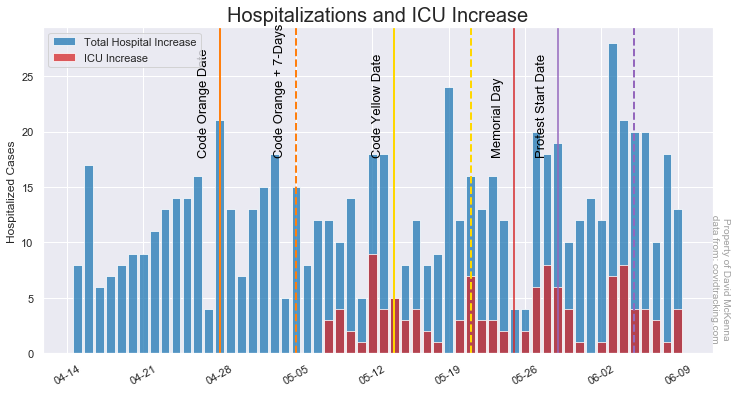

In [12]:
UT_1.sort_index()

UT_1['PreviousDayICU'] = UT_1['inIcuCumulative'].shift(-1)

for row in UT_1.iterrows() :
    UT_1['icuIncrease'] = UT_1['inIcuCumulative'] - UT_1['PreviousDayICU']

UT_1.drop(columns = 'PreviousDayICU',inplace=True)

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
watermark()
my_annotate(text_loc = 18)
ax.bar(UT_1['date'], UT_1['hospitalizedIncrease'],
       label='Total Hospital Increase',color='tab:blue',alpha=0.75)
ax.bar(UT_1['date'], UT_1['icuIncrease'],
       label='ICU Increase',color='tab:red',alpha=0.75)
ax.legend(loc='upper left')
plt.title('Hospitalizations and ICU Increase', fontdict={'fontsize':20})
plt.ylabel('Hospitalized Cases', fontdict={'fontsize':12})
date_ticks()
#plt.savefig('ICU.png')
plt.show()

## Compare UT to nearest states in terms of Deaths per Case
### and Total Cases

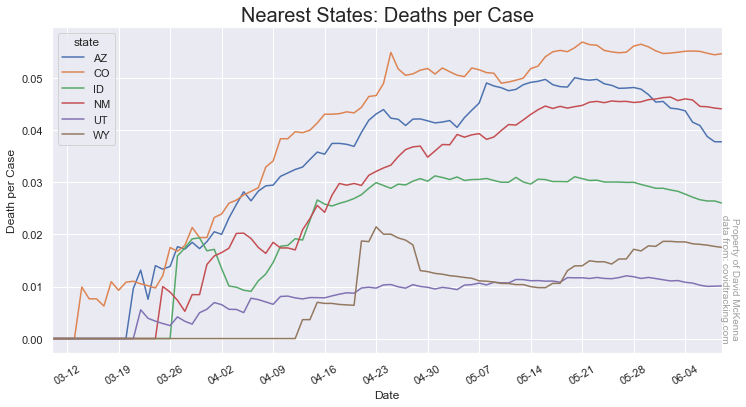

In [13]:
  
df['Date'] = pd.to_datetime(df['date'].astype(str), infer_datetime_format=True)
fc = df[df['state'].isin(['UT','AZ','CO','NM','ID','WY'])]
fc = fc[fc['Date']>= '03-10-2020']


fig, ax = plt.subplots(figsize = (12,6))
watermark()
fig = fc.groupby(['Date','state']).sum()['DperP'].unstack().plot(ax=ax)
date_ticks()
plt.title('Nearest States: Deaths per Case', fontdict={'fontsize':20}) 
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Death per Case', fontdict={'fontsize':12})

plt.show()


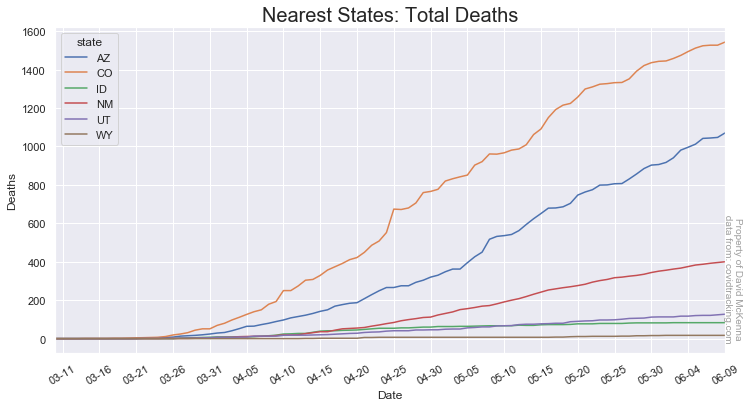

In [14]:
fig, ax = plt.subplots(figsize = (12,6)) 
watermark()
fig = fc.groupby(['date','state']).sum()['death'].unstack().plot(ax=ax)
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=7) 
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=30)

plt.title('Nearest States: Total Deaths' , fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Deaths', fontdict={'fontsize':12})

plt.show()


# Here I look at CA where my family are: 
## This section follows the same as the UT analysis

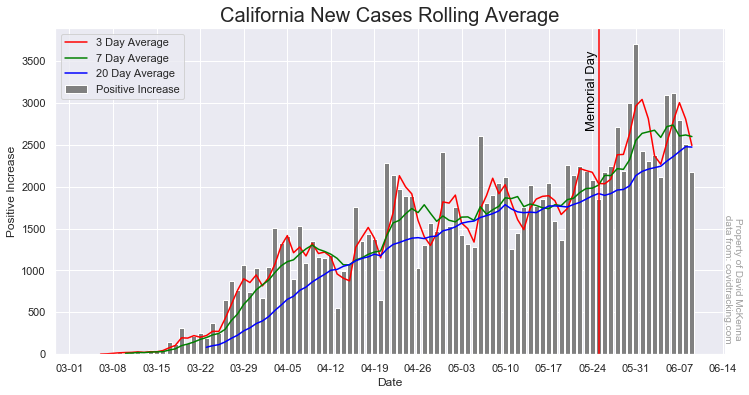

In [15]:
CA = df[df['state']=='CA']
text_loc = max(CA['positiveIncrease'])-1000

CA['rolling_mean'] = CA.loc[:,'positiveIncrease'].rolling(3).mean().shift(periods=-2)
CA['rolling_mean2'] = CA.loc[:,'positiveIncrease'].rolling(7).mean().shift(periods=-6)
CA['rolling_mean3'] = CA.loc[:,'positiveIncrease'].rolling(20).mean().shift(periods=-19)

fig, ax = plt.subplots(figsize = (12,6))
watermark()
date_ticks()

plt.bar(CA['date'], CA['positiveIncrease'], 
        label='Positive Increase',color='grey')
plt.plot(CA['date'], CA.rolling_mean,
         label='3 Day Average', color='red')
plt.plot(CA['date'], CA.rolling_mean2,
         label='7 Day Average', color='green')
plt.plot(CA['date'], CA.rolling_mean3,
         label='20 Day Average', color='blue')
plt.legend(loc='upper left')
ax.axvline( x=MemorialDay, color='red', linewidth=1.5)
ax.annotate('Memorial Day', (MemorialDay - 2 ,text_loc),
            color='black',rotation=90,fontsize=13)
ax.set_xlim(CA['date'].min() , CA['date'].max() )

plt.title('California New Cases Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('CA_Increase_Rolling_Avg.png')
plt.show()

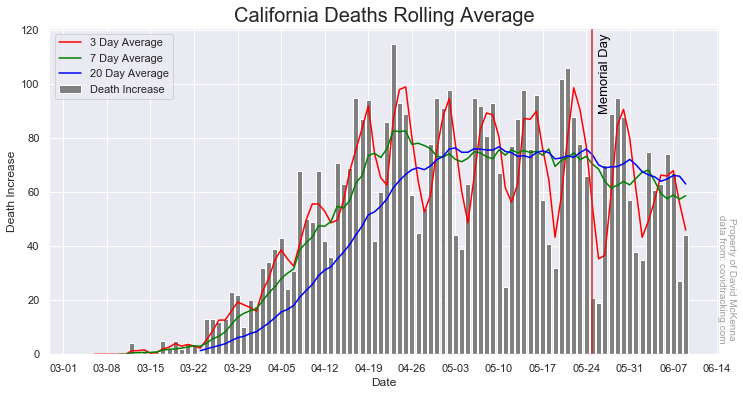

In [16]:
CA['rolling_mean_d'] = CA.loc[:,'deathIncrease'].rolling(3).mean().shift(periods=-2)
CA['rolling_mean_d2'] = CA.loc[:,'deathIncrease'].rolling(7).mean().shift(periods=-6)
CA['rolling_mean_d3'] = CA.loc[:,'deathIncrease'].rolling(20).mean().shift(periods=-19)
CA['date_ordinal'] = pd.to_datetime(CA['date']).apply(lambda date: date.toordinal())

fig, ax = plt.subplots(figsize = (12,6))
watermark()
date_ticks()
plt.bar(CA['date'], CA['deathIncrease'], label='Death Increase',color='grey')
plt.plot(CA['date'], CA.rolling_mean_d, label='3 Day Average', color='red')
plt.plot(CA['date'], CA.rolling_mean_d2, label='7 Day Average', color='green')
plt.plot(CA['date'], CA.rolling_mean_d3, label='20 Day Average', color='blue')
plt.legend(loc='upper left')

ax.axvline( x=MemorialDay, color='tab:red', linewidth=1.5)
ax.annotate('Memorial Day', (MemorialDay + 1 ,90),color='black',rotation=90,fontsize=13)
ax.set_xlim(CA['date_ordinal'].min() , CA['date_ordinal'].max() )
plt.title('California Deaths Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Death Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('CA_Death_Rolling_Avg.png')
plt.show()

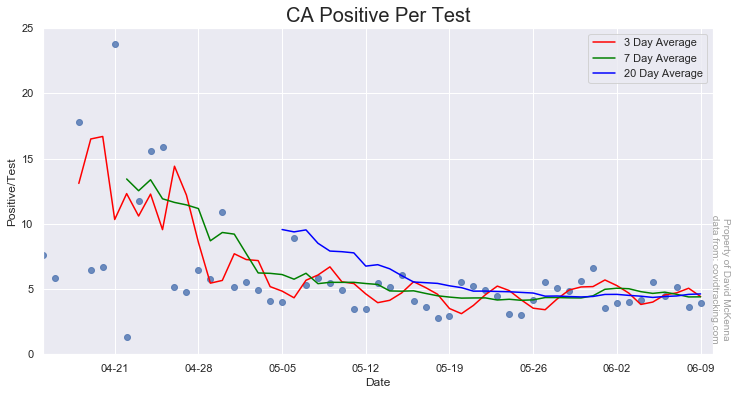

In [20]:
CA_1 = CA[CA['date'] >= '2020-04-15' ]

CA_1['rolling_mean'] = CA_1.loc[:,'PosPerTest'].rolling(3).mean().shift(periods=-3)
CA_1['rolling_mean2'] = CA_1.loc[:,'PosPerTest'].rolling(7).mean().shift(periods=-7)
CA_1['rolling_mean3'] = CA_1.loc[:,'PosPerTest'].rolling(20).mean().shift(periods=-20)

fig, ax = plt.subplots(figsize = (12,6))
watermark()
date_ticks()

fig = sns.regplot(x = 'date_ordinal', y = 'PosPerTest', data = CA, fit_reg=False)
plt.plot(CA_1['date'], CA_1.rolling_mean, label='3 Day Average', color='red')
plt.plot(CA_1['date'], CA_1.rolling_mean2, label='7 Day Average', color='green')
plt.plot(CA_1['date'], CA_1.rolling_mean3, label='20 Day Average', color='blue')

plt.legend(loc='upper right')
ax.set_xlim(CA_1['date_ordinal'].min() , CA_1['date_ordinal'].max()+ 1 )
ax.set_ylim(0,25)
plt.title('CA Positive Per Test', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive/Test', fontdict={'fontsize':12})

#plt.savefig('CA_Positive_Per_Test.png')
plt.show()

## Here we have the 10 states with the largest case increases averaged over a week

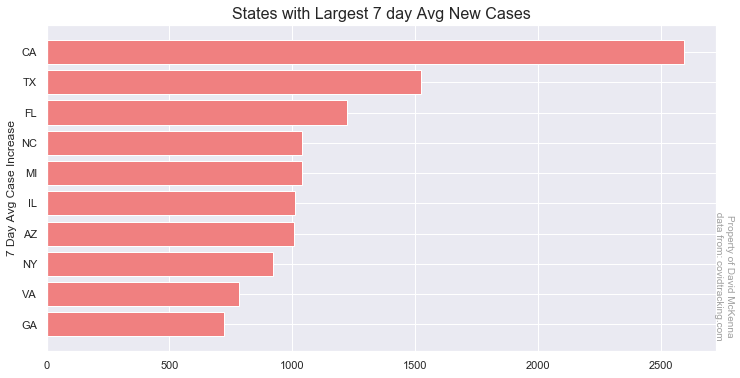

In [18]:
df_1 = df[['state','date','positiveIncrease','deathIncrease']].reset_index()

today = str(df.date.max())

df_1['date_mod'] = pd.to_datetime(df_1['date'], format= '%Y%m%d')
df_1.set_index(['state','date_mod'],inplace=True)
df_1.sort_index(inplace=True)
df_1['date_ordinal'] = pd.to_datetime(df_1['date']).apply(lambda date: date.toordinal())
df_1['posDiff'] = df_1.groupby(level='state')['positiveIncrease'].apply(lambda x: (x.rolling(7).sum() / 7))

largest = df_1[df_1['date']==today]['posDiff'].nlargest(10).astype(int)
fig, ax = plt.subplots(figsize = (12,6))
watermark()

df_2 = pd.DataFrame(largest).reset_index().sort_index(ascending=False)
plt.barh(df_2.state,df_2.posDiff,color = 'lightcoral')
plt.title('States with Largest 7 day Avg New Cases', fontsize=16)
plt.ylabel('7 Day Avg Case Increase')

#plt.savefig('Top_Ten_Increase.png')
plt.show()